In [44]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Gold ("Close") returns with *lagged* Gold returns. 

In [45]:
# Futures contract on the Gold price:

gold = pd.read_csv(
    Path("gold.csv"), index_col="Date",parse_dates=True
)
gold.head()

,Close,Volume,Open,High,Low
Date,,,,,
2014-12-15,1207.7,145843,1222.0,1225.0,1191.3
2014-12-16,1194.3,221571,1195.4,1223.9,1187.8
2014-12-17,1194.5,154962,1195.3,1203.1,1182.0
2014-12-18,1194.8,129127,1189.4,1213.9,1188.5
2014-12-19,1196.0,68747,1198.0,1201.5,1193.2


In [46]:
# Trim the dataset to begin on December 15, 2014
gold = gold.loc["2014-12-15":,:]
gold.head()



,Close,Volume,Open,High,Low
Date,,,,,
2014-12-15,1207.7,145843,1222.0,1225.0,1191.3
2014-12-16,1194.3,221571,1195.4,1223.9,1187.8
2014-12-17,1194.5,154962,1195.3,1203.1,1182.0
2014-12-18,1194.8,129127,1189.4,1213.9,1188.5
2014-12-19,1196.0,68747,1198.0,1201.5,1193.2


# Data Preparation

### Returns

In [47]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
gold['Return'] = gold.Close.pct_change() * 100
gold = gold.replace(-np.inf, np.nan).dropna()
gold.tail()

,Close,Volume,Open,High,Low,Return
Date,,,,,,
2019-12-09,1464.9,163682,1464.1,1469.8,1463.0,0.397505
2019-12-10,1462.6,367,1460.7,1467.2,1460.7,-0.157007
2019-12-11,1475.0,247053,1479.1,1479.9,1478.7,0.847805
2019-12-12,1472.3,396657,1469.5,1474.9,1468.2,-0.183051
2019-12-13,1475.6,468,1463.1,1475.9,1463.1,0.224139


### Lagged Returns 

In [48]:
# Create a lagged return using the shift function
gold['Lagged_Return'] = gold.Return.shift()
gold = gold.replace(-np.inf, np.nan).dropna()
gold.tail()

,Close,Volume,Open,High,Low,Return,Lagged_Return
Date,,,,,,,
2019-12-09,1464.9,163682,1464.1,1469.8,1463.0,0.397505,-1.618232
2019-12-10,1462.6,367,1460.7,1467.2,1460.7,-0.157007,0.397505
2019-12-11,1475.0,247053,1479.1,1479.9,1478.7,0.847805,-0.157007
2019-12-12,1472.3,396657,1469.5,1474.9,1468.2,-0.183051,0.847805
2019-12-13,1475.6,468,1463.1,1475.9,1463.1,0.224139,-0.183051


### Train Test Split

In [49]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = gold[:'2018']
test = gold['2018':]


In [50]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [51]:
X_train.head()

,Lagged_Return
Date,
2014-12-17,-1.109547
2014-12-18,0.016746
2014-12-19,0.025115
2014-12-22,0.100435
2014-12-23,-1.354515


# Linear Regression Model

In [52]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [53]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [54]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
#Results.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F391248048>,
      dtype=object)

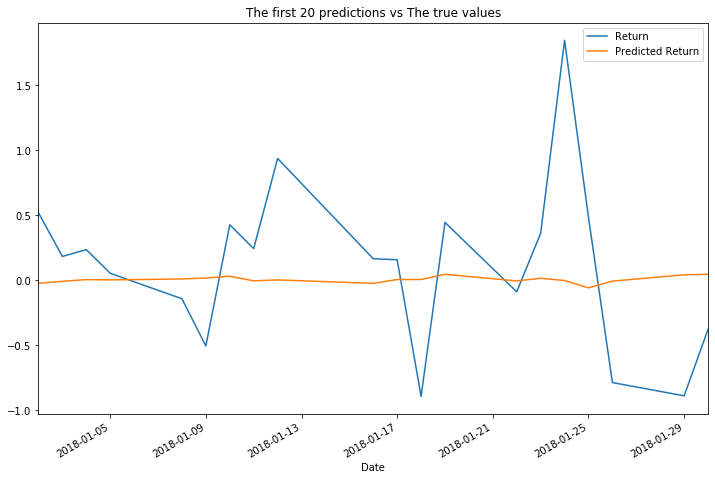

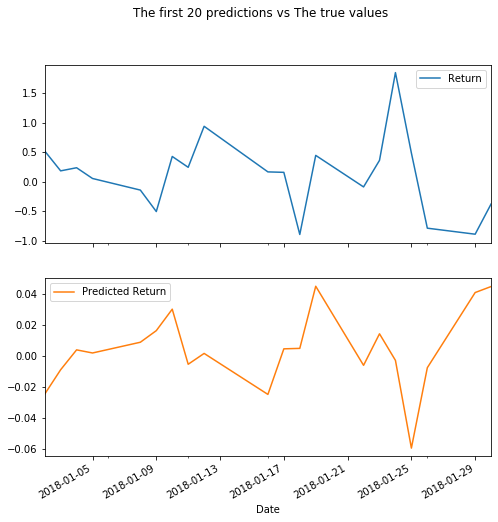

In [55]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='The first 20 predictions vs The true values', figsize=(12, 8))
Results[:20].plot(subplots=True, figsize=(8, 8), title='The first 20 predictions vs The true values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [56]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.733301036079476


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [57]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.8401863235705398


# Conclusions

YOUR CONCLUSIONS HERE!

### lower RMSE is the the sign of fitness of our model, that is why this model perform better with in-Sample data utilization! 